### 3. Comparison and policy exploration ###

In notebook "1_open_exploration_base_case" the scenario space was explored under the 'base case' policy. In this notebook the policy space will be explored by rinning 100 random policies for 500 scenarions and the results with the 'base case' policy will be compared to examine if any policy implementation improve the situation. 

In [3]:
# Import libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Import workbench libraries and the model itself
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import pairs_plotting, plotting
from ema_workbench.util import ema_logging, utilities
from ema_workbench import save_results
from ema_workbench import load_results

from problem_formulation_new import get_model_for_problem_formulation
from dike_model_function import DikeNetwork 

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

We run the workbench with 500 scenarios per random generated policy, and we instantiate 100 policies; resulting in 50000 experiments. After running, we load in the results from the policy and base case run since we don't need to run it each time we run the notebook. Afterwards, we merge them in dataframes and append a column policy (which is random or basecase), so we can distinct the outcomes and more easily visualize them.

In [10]:
# # This part is commented out because the results are loaded from a csv file.
# # Import case function
# # Choose problem formulation number, between 0-5
# dike_model, planning_steps = get_model_for_problem_formulation(5)

# def sum_over(*args):
#     return sum(args)

# # Running experiments
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=500, policies=100)

# # Saving results
# utilities.save_results(results, 'results/500_scenarios_100_policies.csv')

# Load in the results, for both the with and the without policy runs.
experiments, outcomes = utilities.load_results('results/500_scenarios_100_policies.csv')
experiments_base, outcomes_base = utilities.load_results('results/5000_scenarios_base_case.csv')

# Transform the outcomes to a dataframe.
df_outcomes = pd.DataFrame(outcomes)
df_outcomes_base = pd.DataFrame(outcomes_base)

# Merge the seperate dataframes into one.
experiments_combined = pd.concat([experiments, experiments_base], sort = True)
outcomes_combined = pd.concat([df_outcomes, df_outcomes_base], sort = True)

# Rename all the runs that include policy to "random" (indicating random policies), and all the others keep their original name of 'base case'
experiments_combined.loc[experiments_combined["policy"] != "base case", "policy"] = "random"

# And add them to a column within the combined outcomes dataframe
policies = experiments_combined["policy"]
outcomes_combined["policy"] = policies

[MainProcess/INFO] results loaded succesfully from C:\Users\ASUS\PycharmProjects\EPA1361\EPA1361_final\results\500_scenarios_100_policies.csv
[MainProcess/INFO] results loaded succesfully from C:\Users\ASUS\PycharmProjects\EPA1361\EPA1361_final\results\5000_scenarios_base_case.csv


With the retrieved "outcomes_combined" dataframe, we can aggregate the variables in order to visualize them against each other.

We implement the aggregate function 'aggregate_kpi' created in notebook "1_open_exploration_base_case" and calculate the aggregated variables.

In [12]:
# The following function is used to aggregate the outcomes into the KPI we want
# This iterates over all the locations and round numbers, and creates a new column summing the values per location and round.
# If we want to aggregate over the location, "aggregate" equals "location" and therefore the KPI is added per location and not in total.
# If we want to aggregate over the province, "aggregate" equals "name of the province" and therefore the KPI is added per location and not in total
# On the contrary, if aggregate equals "total", the total value is appended to the dataframe.
def aggregate_kpi(data, kpi, aggregate):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    kpi_columns = []
    
    if kpi == "RfR Total Costs" or kpi == "Expected Evacuation Costs":
        kpi_columns.append(kpi + " 0")
        kpi_columns.append(kpi + " 1")
        kpi_columns.append(kpi + " 2")
        
        data[kpi] = data[kpi_columns].sum(axis=1)
    else:
        if aggregate == "total":
            for location in locations:
                kpi_columns.append(location + "_" + kpi + " 0")
                kpi_columns.append(location + "_" + kpi + " 1")
                kpi_columns.append(location + "_" + kpi + " 2")

            data[kpi] = data[kpi_columns].sum(axis=1)
            
        elif aggregate == "Overijssel":
            for location in locations:
                if location == "A.4" or location == "A.5":
                    kpi_columns = []
                    kpi_columns.append(location + "_" + kpi + " 0")
                    kpi_columns.append(location + "_" + kpi + " 1")
                    kpi_columns.append(location + "_" + kpi + " 2")
                    
            data["Overijssel" + "_" + kpi] = data[kpi_columns].sum(axis=1)
      
        elif aggregate == "Gelderland":
            for location in locations:
                if location == "A.1" or location == "A.2"  or location == "A.3":
                    kpi_columns = []
                    kpi_columns.append(location + "_" + kpi + " 0")
                    kpi_columns.append(location + "_" + kpi + " 1")
                    kpi_columns.append(location + "_" + kpi + " 2")

            data["Gelderland" + "_" + kpi] = data[kpi_columns].sum(axis=1)
            
        else:
            for location in locations:
                kpi_columns = []
                kpi_columns.append(location + "_" + kpi + " 0")
                kpi_columns.append(location + "_" + kpi + " 1")
                kpi_columns.append(location + "_" + kpi + " 2")

                data[location + "_" + kpi] = data[kpi_columns].sum(axis=1)
                
    return data

In [13]:
# Append the KPIs we would like to analyse.

outcomes_combined = outcomes_combined.reset_index(drop=True)
outcomes_combined = aggregate_kpi(outcomes_combined, "Expected Number of Deaths", "total")
outcomes_combined = aggregate_kpi(outcomes_combined, "RfR Total Costs", "total")
outcomes_combined = aggregate_kpi(outcomes_combined, "Expected Evacuation Costs", "total")
outcomes_combined = aggregate_kpi(outcomes_combined, "Expected Annual Damage", "Overijssel")
outcomes_combined = aggregate_kpi(outcomes_combined, "Expected Annual Damage", "Gelderland")
outcomes_combined = aggregate_kpi(outcomes_combined, "Dike Investment Costs", "Overijssel")
outcomes_combined = aggregate_kpi(outcomes_combined, "Dike Investment Costs", "Gelderland")

In [16]:
outcomes_combined.head()

,A.1_Dike Investment Costs 0,A.1_Dike Investment Costs 1,A.1_Dike Investment Costs 2,A.1_Expected Annual Damage 0,A.1_Expected Annual Damage 1,A.1_Expected Annual Damage 2,A.1_Expected Number of Deaths 0,A.1_Expected Number of Deaths 1,A.1_Expected Number of Deaths 2,A.2_Dike Investment Costs 0,...,RfR Total Costs 1,RfR Total Costs 2,policy,Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Overijssel_Expected Annual Damage,Gelderland_Expected Annual Damage,Overijssel_Dike Investment Costs,Gelderland_Dike Investment Costs
0,9.510733e+07,1.067683e+08,0,0.0,0.0,0.0,0.0,0.0,0.0,5.335857e+07,...,30700000.0,121200000.0,random,0.000580,710400000.0,171.567079,0.000000e+00,0.000000e+00,1.069766e+08,8.511741e+07
1,9.510733e+07,1.067683e+08,0,0.0,0.0,0.0,0.0,0.0,0.0,5.335857e+07,...,30700000.0,121200000.0,random,0.003759,710400000.0,1345.966416,2.027169e+07,0.000000e+00,1.069766e+08,8.511741e+07
2,9.510733e+07,1.067683e+08,0,0.0,0.0,0.0,0.0,0.0,0.0,5.335857e+07,...,30700000.0,121200000.0,random,0.000094,710400000.0,60.019692,0.000000e+00,0.000000e+00,1.069766e+08,8.511741e+07
3,9.510733e+07,1.067683e+08,0,0.0,0.0,0.0,0.0,0.0,0.0,5.335857e+07,...,30700000.0,121200000.0,random,0.000000,710400000.0,0.000000,0.000000e+00,0.000000e+00,1.069766e+08,8.511741e+07
4,9.510733e+07,1.067683e+08,0,0.0,0.0,0.0,0.0,0.0,0.0,5.335857e+07,...,30700000.0,121200000.0,random,0.007787,710400000.0,1405.596354,9.106152e+06,2.067275e+07,1.069766e+08,8.511741e+07


In [17]:
df_ooi = outcomes_combined[["policy", 'Expected Number of Deaths','RfR Total Costs',
                            'Expected Evacuation Costs', 'Overijssel_Expected Annual Damage',
                            'Gelderland_Expected Annual Damage','Overijssel_Dike Investment Costs',
                            'Gelderland_Dike Investment Costs']]

### Visualization of the retrieved outcomes ###

With the retrieved dataframe df_ooi, we can visualize the following KPIs. This now includes total policy costs:

% add KPIs

% add summery of the findings

No handles with labels found to put in legend.


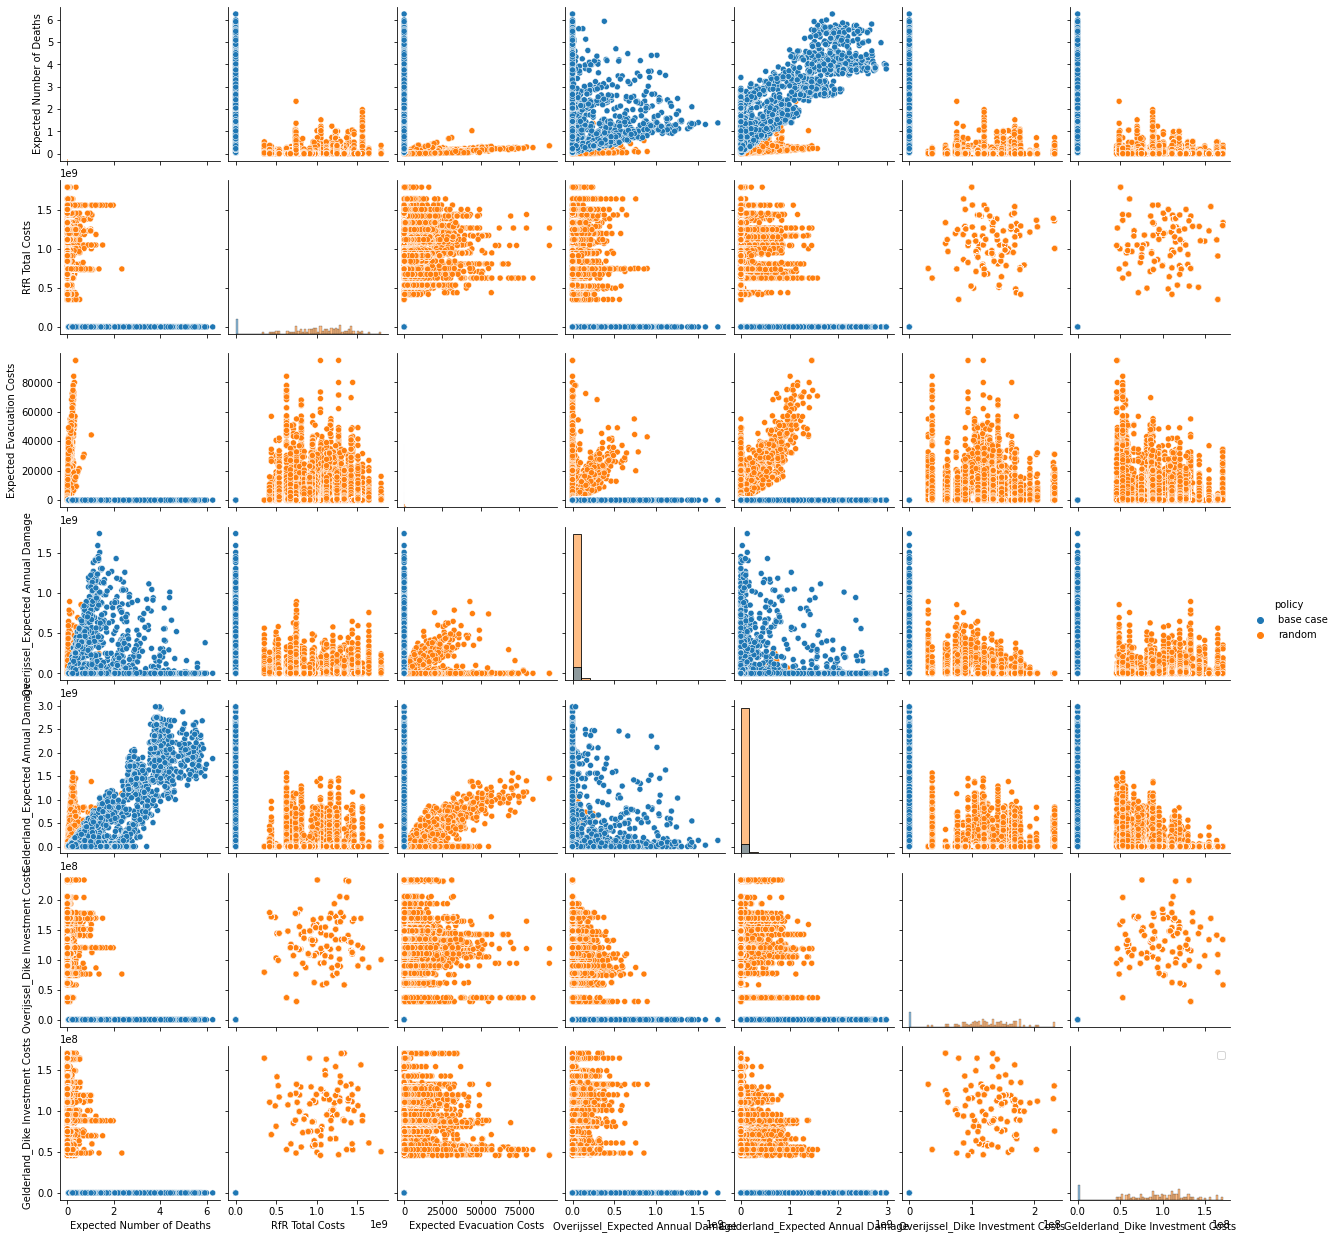

In [19]:
#Now that a combined dataframe has been created, plotting the base case against the random policy runs is now easy.
sns.pairplot(df_ooi, hue='policy', hue_order=["base case", "random"], vars=['Expected Number of Deaths','RfR Total Costs',
                            'Expected Evacuation Costs', 'Overijssel_Expected Annual Damage',
                            'Gelderland_Expected Annual Damage','Overijssel_Dike Investment Costs',
                            'Gelderland_Dike Investment Costs'], diag_kind="hist")
plt.legend()
plt.show()